# Data Preperation for Streamlit Powerplants Implementation
Our Powerplants data contains specifics about green and non-green energy on individual coordinates.

In this session we want to create a nice looking web-page that let's us easily compare statistics between individual countries.

In order to do this we have to aggregate our individual coordinate-based data to per-country data.

## Imports

In [2]:
import geopandas as gpd
import pandas as pd
import folium
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

## Load Raw Data

In [3]:
# load data on european countries
europe = pd.read_pickle("../data/europe.p").to_crs("EPSG:4326")
# contains all countries intersecting our polygon from the WW2 analysis
europe.sample(5)# not only european countries per se
# columns of interest for us: name and geometry
europe.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,142257519,Europe,Russia,RUS,3745000.0,"MULTIPOLYGON (((45.00000 42.60827, 44.53762 42.71199, 43.93121 42.55496, 43.75599 42.74083, 42.3..."
1,5320045,Europe,Norway,-99,364700.0,"POLYGON ((31.10104 69.55810, 29.39955 69.15692, 28.59193 69.06478, 29.01557 69.76649, 27.73229 7..."
2,57713,North America,Greenland,GRL,2173.0,"POLYGON ((-20.72922 73.50000, -20.76234 73.46436, -22.17221 73.30955, -23.56593 73.30663, -22.31..."
3,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((8.74601 42.62812, 9.39000 43.00998, 9.56002 42.15249, 9.22975 41.38001, 8.77572 ..."
4,8299706,Asia,Israel,ISR,297000.0,"POLYGON ((35.05295 33.00000, 35.09846 33.08054, 35.12605 33.09090, 35.46071 33.08904, 35.55280 3..."


In [4]:
europe.shape

(56, 6)

In [5]:
# load Powerplants data for target_df
# geometry contains coordinate POINTS
europe_data = pd.read_pickle("../data/gdf_europe.p").to_crs("EPSG:4326")
europe_data.head()

,country code,country,name of powerplant,capacity in MW,latitude,longitude,primary_fuel,start date,owner of plant,geolocation_source,estimated_generation_gwh_2020,green,continent,geometry
9,ALB,Albania,Bistrica 1,27.0,39.9116,20.1047,Hydro,1965,NaN,GEODB,88.45,True,Europe,POINT (20.10470 39.91160)
10,ALB,Albania,Fierza,500.0,42.2514,20.0431,Hydro,1978,NaN,GEODB,1648.24,True,Europe,POINT (20.04310 42.25140)
11,ALB,Albania,Koman,600.0,42.1033,19.8224,Hydro,1985,NaN,GEODB,1982.72,True,Europe,POINT (19.82240 42.10330)
12,ALB,Albania,Lanabregas,5.0,41.3428,19.8964,Hydro,1951,NaN,GEODB,15.23,True,Europe,POINT (19.89640 41.34280)
13,ALB,Albania,Shkopet,24.0,41.6796,19.8305,Hydro,1963,NaN,GEODB,83.57,True,Europe,POINT (19.83050 41.67960)


In [6]:
europe_data.shape

(9969, 14)

## Replace coordinates by countries polygons

In [7]:
res_intersect_europe = gpd.overlay(europe_data, europe, how='intersection')
# Basically checks for each geometry in "europe_data" (target coordinates) 
# if intersects with geometry of "target_df" (country)
# -> Merges both dataframes and keeps country polygon instead of target coordinates
res_intersect_europe.head()

,country code,country,name of powerplant,capacity in MW,latitude,longitude,primary_fuel,start date,owner of plant,geolocation_source,estimated_generation_gwh_2020,green,continent_1,pop_est,continent_2,name,iso_a3,gdp_md_est,geometry
0,ALB,Albania,Bistrica 1,27.0,39.9116,20.1047,Hydro,1965,NaN,GEODB,88.45,True,Europe,3047987,Europe,Albania,ALB,33900.0,POINT (20.10470 39.91160)
1,ALB,Albania,Fierza,500.0,42.2514,20.0431,Hydro,1978,NaN,GEODB,1648.24,True,Europe,3047987,Europe,Albania,ALB,33900.0,POINT (20.04310 42.25140)
2,ALB,Albania,Koman,600.0,42.1033,19.8224,Hydro,1985,NaN,GEODB,1982.72,True,Europe,3047987,Europe,Albania,ALB,33900.0,POINT (19.82240 42.10330)
3,ALB,Albania,Lanabregas,5.0,41.3428,19.8964,Hydro,1951,NaN,GEODB,15.23,True,Europe,3047987,Europe,Albania,ALB,33900.0,POINT (19.89640 41.34280)
4,ALB,Albania,Shkopet,24.0,41.6796,19.8305,Hydro,1963,NaN,GEODB,83.57,True,Europe,3047987,Europe,Albania,ALB,33900.0,POINT (19.83050 41.67960)


In [8]:
res_intersect_europe.shape

(9969, 19)

In [9]:
# Set index to country name so we can directly insert data grouped by country name
europe.set_index("name", inplace=True, drop=False)

In [10]:
def insert_totals(target_df, data_df):
    # get powerplant counts and green ratio
    # and apply it to a given target country
    # get totals
    target_df[f"N_powerplants"] = data_df.groupby("name").size()
    target_df[f"N_green"] = data_df.loc[data_df["green"]].groupby("name").size()
    # replace NaN (no a number) values with 0
    target_df.fillna(0, inplace=True)
    n_green = data_df.groupby(["name", "green"])["name"].size().unstack()
    target_df["green_ratio"] = (n_green[True] / n_green.sum(axis=1)).fillna(0)
    return target_df

In [11]:
europe = insert_totals(europe, res_intersect_europe)

In [12]:
europe.head(1)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,N_powerplants,N_green,green_ratio
name,,,,,,,,,
Russia,142257519,Europe,Russia,RUS,3745000.0,"MULTIPOLYGON (((45.00000 42.60827, 44.53762 42.71199, 43.93121 42.55496, 43.75599 42.74083, 42.3...",229.0,81.0,0.353712


In [13]:
europe = europe.loc[europe["continent"] == "Europe"]

In [14]:
def insert_fuel_types(target_df, data_df):
    for pp_type in data_df["primary_fuel"].unique():
        target_df[f"N_fuel_{pp_type}"] = data_df.loc[data_df["primary_fuel"] == pp_type].groupby("name").size()
        data_df.loc[data_df["primary_fuel"] == pp_type, f"is_{pp_type}"] = True
        data_df.loc[data_df["primary_fuel"] != pp_type, f"is_{pp_type}"] = False 
        ratio = data_df.groupby(["name", f"is_{pp_type}"]).size().unstack().fillna(0)
        target_df[f"fuel_ratio_{pp_type}"] = ratio[True] / ratio.sum(axis=1)

        production = data_df.groupby(["name", f"is_{pp_type}"])["estimated_generation_gwh_2020"].sum().unstack().fillna(0)

        target_df[f"fuel_generation_ratio_{pp_type}"] = production[True] / production.sum(axis=1)
        target_df[f"fuel_generation_total_{pp_type}"] = production[True]
    return target_df

In [15]:
europe = insert_fuel_types(europe, res_intersect_europe).fillna(0)

In [16]:
europe.shape

(39, 65)

In [17]:
europe.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,N_powerplants,N_green,green_ratio,N_fuel_Hydro,fuel_ratio_Hydro,fuel_generation_ratio_Hydro,fuel_generation_total_Hydro,N_fuel_Other,fuel_ratio_Other,fuel_generation_ratio_Other,fuel_generation_total_Other,N_fuel_Gas,fuel_ratio_Gas,fuel_generation_ratio_Gas,fuel_generation_total_Gas,N_fuel_Wind,fuel_ratio_Wind,fuel_generation_ratio_Wind,fuel_generation_total_Wind,N_fuel_Solar,fuel_ratio_Solar,fuel_generation_ratio_Solar,fuel_generation_total_Solar,N_fuel_Waste,fuel_ratio_Waste,fuel_generation_ratio_Waste,fuel_generation_total_Waste,N_fuel_Biomass,fuel_ratio_Biomass,fuel_generation_ratio_Biomass,fuel_generation_total_Biomass,N_fuel_Coal,fuel_ratio_Coal,fuel_generation_ratio_Coal,fuel_generation_total_Coal,N_fuel_Nuclear,fuel_ratio_Nuclear,fuel_generation_ratio_Nuclear,fuel_generation_total_Nuclear,N_fuel_Oil,fuel_ratio_Oil,fuel_generation_ratio_Oil,fuel_generation_total_Oil,N_fuel_Geothermal,fuel_ratio_Geothermal,fuel_generation_ratio_Geothermal,fuel_generation_total_Geothermal,N_fuel_Wave and Tidal,fuel_ratio_Wave and Tidal,fuel_generation_ratio_Wave and Tidal,fuel_generation_total_Wave and Tidal,N_fuel_Storage,fuel_ratio_Storage,fuel_generation_ratio_Storage,fuel_generation_total_Storage,N_fuel_Cogeneration,fuel_ratio_Cogeneration,fuel_generation_ratio_Cogeneration,fuel_generation_total_Cogeneration
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Russia,142257519,Europe,Russia,RUS,3745000.0,"MULTIPOLYGON (((45.00000 42.60827, 44.53762 42.71199, 43.93121 42.55496, 43.75599 42.74083, 42.3...",229.0,81.0,0.353712,62.0,0.270742,0.064986,27937.63,1.0,0.004367,0.0,0.0,124.0,0.541485,0.496539,213462.81,1.0,0.004367,0.000023,9.89,16.0,0.069869,0.001669,717.35,0.0,0.0,0.0,0.0,2.0,0.008734,0.0,0.0,11.0,0.048035,0.060436,25981.30,7.0,0.030568,0.376087,161680.26,5.0,0.021834,0.000260,111.75,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Norway,5320045,Europe,Norway,-99,364700.0,"POLYGON ((31.10104 69.55810, 29.39955 69.15692, 28.59193 69.06478, 29.01557 69.76649, 27.73229 7...",288.0,285.0,0.989583,277.0,0.961806,0.971880,114691.64,0.0,0.000000,0.0,0.0,3.0,0.010417,0.020032,2363.94,8.0,0.027778,0.008089,954.56,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
France,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((8.74601 42.62812, 9.39000 43.00998, 9.56002 42.15249, 9.22975 41.38001, 8.77572 ...",2038.0,2004.0,0.983317,412.0,0.202159,0.131952,60827.46,0.0,0.000000,0.0,0.0,8.0,0.003925,0.040102,18486.30,702.0,0.344455,0.035496,16362.92,746.0,0.366045,0.016138,7439.21,0.0,0.0,0.0,0.0,143.0,0.070167,0.0,0.0,5.0,0.002453,0.035402,16319.68,16.0,0.007851,0.730729,336853.38,5.0,0.002453,0.010181,4693.46,0.0,0.0,0.0,0.0,1.0,0.000491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sweden,9960487,Europe,Sweden,SWE,498100.0,"POLYGON ((11.02737 58.85615, 11.46827 59.43239, 12.30037 60.11793, 12.63115 61.29357, 11.99206 6...",164.0,157.0,0.957317,144.0,0.878049,0.477205,48293.54,0.0,0.000000,0.0,0.0,3.0,0.018293,0.004196,424.64,7.0,0.042683,0.014521,1469.51,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,6.0,0.036585,0.0,0.0,1.0,0.006098,0.000000,0.00,2.0,0.012195,0.503234,50927.73,1.0,0.006098,0.000844,85.38,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belarus,9549747,Europe,Belarus,BLR,165400.0,"POLYGON ((28.17671 56.16913, 29.22951 55.91834, 29.37157 55.67009, 29.89629 55.78946, 30.87391 5...",24.0,7.0,0.291667,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,17.0,0.708333,0.989825,33619.53,0.0,0.000000,0.000000,0.00,7.0,0.291667,0.010175,345.59,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
europe = europe.drop('name',axis=1)

In [19]:
europe = europe.reset_index()
europe = europe.fillna(0)
europe['id'] = europe.index # Work around German Umlaute

In [21]:
europe.to_file('Europa.geojson', driver="GeoJSON",index=False,encoding='latin1')
europe.to_csv('Europa.csv',index=False,encoding='latin1')
europe_df = pd.read_csv('Europa.csv',encoding='latin1')
europe_df.head()

,name,pop_est,continent,iso_a3,gdp_md_est,geometry,N_powerplants,N_green,green_ratio,N_fuel_Hydro,fuel_ratio_Hydro,fuel_generation_ratio_Hydro,fuel_generation_total_Hydro,N_fuel_Other,fuel_ratio_Other,fuel_generation_ratio_Other,fuel_generation_total_Other,N_fuel_Gas,fuel_ratio_Gas,fuel_generation_ratio_Gas,fuel_generation_total_Gas,N_fuel_Wind,fuel_ratio_Wind,fuel_generation_ratio_Wind,fuel_generation_total_Wind,N_fuel_Solar,fuel_ratio_Solar,fuel_generation_ratio_Solar,fuel_generation_total_Solar,N_fuel_Waste,fuel_ratio_Waste,fuel_generation_ratio_Waste,fuel_generation_total_Waste,N_fuel_Biomass,fuel_ratio_Biomass,fuel_generation_ratio_Biomass,fuel_generation_total_Biomass,N_fuel_Coal,fuel_ratio_Coal,fuel_generation_ratio_Coal,fuel_generation_total_Coal,N_fuel_Nuclear,fuel_ratio_Nuclear,fuel_generation_ratio_Nuclear,fuel_generation_total_Nuclear,N_fuel_Oil,fuel_ratio_Oil,fuel_generation_ratio_Oil,fuel_generation_total_Oil,N_fuel_Geothermal,fuel_ratio_Geothermal,fuel_generation_ratio_Geothermal,fuel_generation_total_Geothermal,N_fuel_Wave and Tidal,fuel_ratio_Wave and Tidal,fuel_generation_ratio_Wave and Tidal,fuel_generation_total_Wave and Tidal,N_fuel_Storage,fuel_ratio_Storage,fuel_generation_ratio_Storage,fuel_generation_total_Storage,N_fuel_Cogeneration,fuel_ratio_Cogeneration,fuel_generation_ratio_Cogeneration,fuel_generation_total_Cogeneration
0,Russia,142257519,Europe,RUS,3745000.0,"MULTIPOLYGON (((45 42.60827297682149, 44.537622918481986 42.71199270280363, 43.931210000000135 4...",229.0,81.0,0.353712,62.0,0.270742,0.064986,27937.63,1.0,0.004367,0.0,0.0,124.0,0.541485,0.496539,213462.81,1.0,0.004367,0.000023,9.89,16.0,0.069869,0.001669,717.35,0.0,0.0,0.0,0.0,2.0,0.008734,0.0,0.0,11.0,0.048035,0.060436,25981.30,7.0,0.030568,0.376087,161680.26,5.0,0.021834,0.000260,111.75,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Norway,5320045,Europe,-99,364700.0,"POLYGON ((31.101042202597625 69.55810108805622, 29.399550000000033 69.15692000000013, 28.5919295...",288.0,285.0,0.989583,277.0,0.961806,0.971880,114691.64,0.0,0.000000,0.0,0.0,3.0,0.010417,0.020032,2363.94,8.0,0.027778,0.008089,954.56,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,France,67106161,Europe,-99,2699000.0,"MULTIPOLYGON (((8.746009148807559 42.62812185319392, 9.390000848028876 43.00998484961471, 9.5600...",2038.0,2004.0,0.983317,412.0,0.202159,0.131952,60827.46,0.0,0.000000,0.0,0.0,8.0,0.003925,0.040102,18486.30,702.0,0.344455,0.035496,16362.92,746.0,0.366045,0.016138,7439.21,0.0,0.0,0.0,0.0,143.0,0.070167,0.0,0.0,5.0,0.002453,0.035402,16319.68,16.0,0.007851,0.730729,336853.38,5.0,0.002453,0.010181,4693.46,0.0,0.0,0.0,0.0,1.0,0.000491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sweden,9960487,Europe,SWE,498100.0,"POLYGON ((11.027368605196868 58.85614940045936, 11.468271925511146 59.43239329694604, 12.3003658...",164.0,157.0,0.957317,144.0,0.878049,0.477205,48293.54,0.0,0.000000,0.0,0.0,3.0,0.018293,0.004196,424.64,7.0,0.042683,0.014521,1469.51,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,6.0,0.036585,0.0,0.0,1.0,0.006098,0.000000,0.00,2.0,0.012195,0.503234,50927.73,1.0,0.006098,0.000844,85.38,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Belarus,9549747,Europe,BLR,165400.0,"POLYGON ((28.17670942557794 56.16912995057879, 29.229513380660308 55.91834422466636, 29.37157189...",24.0,7.0,0.291667,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,17.0,0.708333,0.989825,33619.53,0.0,0.000000,0.000000,0.00,7.0,0.291667,0.010175,345.59,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# German Bundeslaender

In [22]:
# load data containing German Bundesländer
# similarly to the europe dataset it contains polygons mapping individual Bundesländer
bl = gpd.read_file('../data/vg2500_geo84.zip').to_crs("EPSG:4326")
# rename the column that specifies the name so that is the same with the remaining data
bl.rename({"GEN": "name"}, axis=1, inplace=True)

In [23]:
bl.shape

(16, 7)

In [24]:
bl.head()

,USE,RS,RS_ALT,name,SHAPE_LENG,SHAPE_AREA,geometry
0,2,02,020000000000,Hamburg,1.752538e+05,7.605398e+08,"MULTIPOLYGON (((10.19114 53.72299, 10.18210 53.71003, 10.18181 53.70962, 10.15879 53.69080, 10.1..."
1,2,03,030000000000,Niedersachsen,2.016496e+06,4.771641e+10,"MULTIPOLYGON (((8.68962 53.87999, 8.69297 53.87830, 8.70068 53.87991, 8.70166 53.88004, 8.70243 ..."
2,2,04,040000000000,Bremen,1.549716e+05,4.054809e+08,"MULTIPOLYGON (((8.52976 53.21640, 8.55399 53.20863, 8.56548 53.21331, 8.57815 53.21713, 8.59904 ..."
3,2,05,050000000000,Nordrhein-Westfalen,1.352108e+06,3.404727e+10,"POLYGON ((8.66673 52.52149, 8.70289 52.50053, 8.69809 52.48647, 8.70334 52.44430, 8.70447 52.414..."
4,2,06,060000000000,Hessen,1.105093e+06,2.109232e+10,"POLYGON ((9.50560 51.62777, 9.50842 51.62712, 9.51127 51.62670, 9.51398 51.62648, 9.51644 51.626..."


In [25]:
# same as before but now we want to aggregate data for individual Bundesländer
res_intersect_bl = gpd.overlay(europe_data, bl, how='intersection')

In [26]:
res_intersect_bl.sample(5)

,country code,country,name of powerplant,capacity in MW,latitude,longitude,primary_fuel,start date,owner of plant,geolocation_source,estimated_generation_gwh_2020,green,continent,USE,RS,RS_ALT,name,SHAPE_LENG,SHAPE_AREA,geometry
590,DEU,Germany,Ra�nitz Solar Power Plant,7.1,51.3993,12.0801,Solar,-1,NaN,Industry About,10.51,True,Europe,2,15,150000000000,Sachsen-Anhalt,9.490968e+05,2.049498e+10,POINT (12.08010 51.39930)
1089,DEU,Germany,Rackwitz Solar Power Plant,4.2,51.4292,12.3676,Solar,-1,NaN,Industry About,6.10,True,Europe,2,14,140000000000,Sachsen,9.792943e+05,1.840164e+10,POINT (12.36760 51.42920)
552,DEU,Germany,Halle Messe,4.1,51.4548,12.0200,Solar,-1,NaN,Wiki-Solar,5.94,True,Europe,2,15,150000000000,Sachsen-Anhalt,9.490968e+05,2.049498e+10,POINT (12.02000 51.45480)
195,DEU,Germany,Mindorf,6.6,49.1520,11.2520,Solar,-1,NaN,Wiki-Solar,9.28,True,Europe,2,09,090000000000,Bayern,2.046039e+06,7.055007e+10,POINT (11.25200 49.15200)
482,DEU,Germany,Raffineriekraftwerk Köln Godorf,80.0,50.8548,6.9808,Oil,2004,Steag GmbH,Open Power System Data,119.43,False,Europe,2,05,050000000000,Nordrhein-Westfalen,1.352108e+06,3.404727e+10,POINT (6.98080 50.85480)


In [27]:
bl.set_index("name", inplace=True)
bl = insert_totals(bl, res_intersect_bl)
bl = insert_fuel_types(bl, res_intersect_bl)

In [28]:
bl = bl.reset_index()
bl = bl.fillna(0)
bl['id'] = bl.index

In [30]:
bl.to_file('Bundeslaender.geojson', driver="GeoJSON",index=False,encoding='latin1')
bl.to_csv('Bundeslaender.csv',index=False,encoding='latin1')
bl_df = pd.read_csv('Bundeslaender.csv',encoding='latin1')
bl_df.head()

,name,USE,RS,RS_ALT,SHAPE_LENG,SHAPE_AREA,geometry,N_powerplants,N_green,green_ratio,N_fuel_Hydro,fuel_ratio_Hydro,fuel_generation_ratio_Hydro,fuel_generation_total_Hydro,N_fuel_Solar,fuel_ratio_Solar,fuel_generation_ratio_Solar,fuel_generation_total_Solar,N_fuel_Waste,fuel_ratio_Waste,fuel_generation_ratio_Waste,fuel_generation_total_Waste,N_fuel_Biomass,fuel_ratio_Biomass,fuel_generation_ratio_Biomass,fuel_generation_total_Biomass,N_fuel_Oil,fuel_ratio_Oil,fuel_generation_ratio_Oil,fuel_generation_total_Oil,N_fuel_Gas,fuel_ratio_Gas,fuel_generation_ratio_Gas,fuel_generation_total_Gas,N_fuel_Coal,fuel_ratio_Coal,fuel_generation_ratio_Coal,fuel_generation_total_Coal,N_fuel_Nuclear,fuel_ratio_Nuclear,fuel_generation_ratio_Nuclear,fuel_generation_total_Nuclear,N_fuel_Other,fuel_ratio_Other,fuel_generation_ratio_Other,fuel_generation_total_Other,N_fuel_Wind,fuel_ratio_Wind,fuel_generation_ratio_Wind,fuel_generation_total_Wind
0,Hamburg,2,2,20000000000,1.752538e+05,7.605398e+08,"MULTIPOLYGON (((10.19113690277905 53.72299476403796, 10.182096824348678 53.71002525433905, 10.18...",7,1,0.142857,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,1,0.142857,0.005312,50.50,1.0,0.142857,0.0,0.0,1.0,0.142857,0.005967,56.73,2.0,0.285714,0.060943,579.36,2.0,0.285714,0.927777,8819.95,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0
1,Niedersachsen,2,3,30000000000,2.016496e+06,4.771641e+10,"MULTIPOLYGON (((8.689616610395177 53.879992720322285, 8.69297200462773 53.87829828511829, 8.7006...",45,16,0.355556,2.0,0.044444,0.010826,434.16,11.0,0.244444,0.005848,234.54,3,0.066667,0.004801,192.53,3.0,0.066667,0.0,0.0,0.0,0.000000,0.000000,0.00,18.0,0.400000,0.305610,12255.88,5.0,0.111111,0.185606,7443.36,2.0,0.044444,0.463524,18588.72,1.0,0.022222,0.023785,953.84,0.0,0.0,0.0,0.0
2,Bremen,2,4,40000000000,1.549716e+05,4.054809e+08,"MULTIPOLYGON (((8.52975665105563 53.216396506038286, 8.553992132614463 53.20862869551077, 8.5654...",8,1,0.125000,1.0,0.125000,0.008508,41.98,0.0,0.000000,0.000000,0.00,3,0.375000,0.038806,191.47,0.0,0.000000,0.0,0.0,1.0,0.125000,0.059910,295.60,0.0,0.000000,0.000000,0.00,3.0,0.375000,0.892777,4405.04,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0
3,Nordrhein-Westfalen,2,5,50000000000,1.352108e+06,3.404727e+10,"POLYGON ((8.666728266554577 52.52148958107465, 8.702887415877003 52.500526202144705, 8.698086755...",131,24,0.183206,5.0,0.038168,0.005946,834.40,10.0,0.076336,0.000515,72.33,15,0.114504,0.006808,955.27,9.0,0.068702,0.0,0.0,3.0,0.022901,0.002195,307.98,48.0,0.366412,0.246420,34577.24,37.0,0.282443,0.734128,103011.46,0.0,0.000000,0.000000,0.00,4.0,0.030534,0.003987,559.39,0.0,0.0,0.0,0.0
4,Hessen,2,6,60000000000,1.105093e+06,2.109232e+10,"POLYGON ((9.505598958397917 51.62776574465611, 9.508417349910042 51.62712367038471, 9.5112743010...",42,19,0.452381,3.0,0.071429,0.092404,1196.78,13.0,0.309524,0.005394,69.86,4,0.095238,0.017562,227.46,3.0,0.071429,0.0,0.0,1.0,0.023810,0.002858,37.02,12.0,0.285714,0.291229,3771.88,5.0,0.119048,0.585524,7583.47,0.0,0.000000,0.000000,0.00,1.0,0.023810,0.005029,65.13,0.0,0.0,0.0,0.0


## German Landkreise
Let's go even lower than Bundesländer

In [31]:
kreise = gpd.read_file('../data/vg2500_krs.zip').to_crs("EPSG:4326")
kreise.rename({"GEN": "name"}, axis=1, inplace=True)
kreise.sample(5)

,USE,RS,RS_ALT,name,SHAPE_LENG,SHAPE_AREA,geometry
285,4,09565,095650000000,Schwabach,35667.455211,4.321303e+07,"MULTIPOLYGON (((11.05788 49.34135, 11.06820 49.33732, 11.07374 49.33740, 11.08133 49.33952, 11.0..."
39,4,03356,033560000000,Osterholz,142234.443272,6.503919e+08,"POLYGON ((8.91104 53.37911, 8.90788 53.37435, 8.94609 53.36377, 8.97198 53.33822, 8.99800 53.322..."
248,4,09263,092630000000,Straubing,39314.173662,7.059082e+07,"POLYGON ((12.48012 48.87154, 12.51477 48.87338, 12.51428 48.87800, 12.51553 48.89018, 12.51731 4..."
334,4,12064,120640000000,Märkisch-Oderland,267987.824263,2.154915e+09,"POLYGON ((14.12423 52.90356, 14.12957 52.88940, 14.15003 52.89459, 14.15597 52.89543, 14.15764 5..."
222,4,08437,084370000000,Sigmaringen,223505.897790,1.204758e+09,"POLYGON ((9.34751 48.23923, 9.33967 48.23886, 9.33520 48.23695, 9.30668 48.22440, 9.30680 48.218..."


repeat the stepts

In [32]:
res_intersect_kreise = gpd.overlay(europe_data, kreise, how='intersection')

In [33]:
kreise.set_index("name", inplace=True)
kreise = insert_totals(kreise, res_intersect_kreise)
kreise = insert_fuel_types(kreise, res_intersect_kreise)

In [34]:
kreise = kreise.reset_index()
kreise = kreise.fillna(0)
kreise['id'] = kreise.index

In [37]:
kreise.to_file('Landkreise.geojson', driver="GeoJSON",index=False,encoding='latin1')
kreise.to_csv('Landkreise.csv',index=False,encoding='latin1')
kreise_df = pd.read_csv('Landkreise.csv',encoding='latin1')
kreise_df.head()

,name,USE,RS,RS_ALT,SHAPE_LENG,SHAPE_AREA,geometry,N_powerplants,N_green,green_ratio,N_fuel_Hydro,fuel_ratio_Hydro,fuel_generation_ratio_Hydro,fuel_generation_total_Hydro,N_fuel_Solar,fuel_ratio_Solar,fuel_generation_ratio_Solar,fuel_generation_total_Solar,N_fuel_Gas,fuel_ratio_Gas,fuel_generation_ratio_Gas,fuel_generation_total_Gas,N_fuel_Biomass,fuel_ratio_Biomass,fuel_generation_ratio_Biomass,fuel_generation_total_Biomass,N_fuel_Coal,fuel_ratio_Coal,fuel_generation_ratio_Coal,fuel_generation_total_Coal,N_fuel_Other,fuel_ratio_Other,fuel_generation_ratio_Other,fuel_generation_total_Other,N_fuel_Waste,fuel_ratio_Waste,fuel_generation_ratio_Waste,fuel_generation_total_Waste,N_fuel_Wind,fuel_ratio_Wind,fuel_generation_ratio_Wind,fuel_generation_total_Wind,N_fuel_Oil,fuel_ratio_Oil,fuel_generation_ratio_Oil,fuel_generation_total_Oil,N_fuel_Nuclear,fuel_ratio_Nuclear,fuel_generation_ratio_Nuclear,fuel_generation_total_Nuclear
0,Flensburg,4,1001,10010000000,32467.034276,5.324899e+07,"POLYGON ((9.489823260151168 54.82296231149822, 9.504673652057674 54.81004002875278, 9.5049951708...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.000000,958.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Kiel,4,1002,10020000000,73027.302434,1.218654e+08,"POLYGON ((10.190574858682838 54.38909396612953, 10.183698316104081 54.38910380529061, 10.1781475...",2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.070329,120.13,0.0,0.0,0.0,0.0,1.0,0.5,0.929671,1587.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Lübeck,4,1003,10030000000,104861.094220,2.211386e+08,"POLYGON ((10.892971221748953 53.956954865124764, 10.903374439173431 53.957047375648436, 10.90859...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Neumünster,4,1004,10040000000,39858.818376,8.092363e+07,"POLYGON ((10.034541478286 54.129152216881, 10.022771700029574 54.10937690486711, 10.022703338048...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Dithmarschen,4,1051,10510000000,202206.675707,1.450311e+09,"MULTIPOLYGON (((9.051759426136824 54.36640406899298, 9.071925934905774 54.36253959382538, 9.0864...",3.0,3.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,27.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
kreise_df.shape

(402, 50)

In [39]:
kreise.shape

(402, 50)

In [40]:
kreise_df.isnull().sum().sum()

0

In [41]:
kreise.isnull().sum().sum()

0

In [42]:
kreise.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_data = pd.read_pickle("../data/gdf_world.p").to_crs("EPSG:4326")
res_intersect_world = gpd.overlay(world_data, world, how='intersection')

In [44]:
world.set_index("name", inplace=True)
world = insert_totals(world, res_intersect_world)
world = insert_fuel_types(world, res_intersect_world)

In [45]:
world = world.reset_index()
world = world.fillna(0)
world['id'] = world.index

In [47]:
world.to_file('Welt.geojson', driver="GeoJSON",index=False,encoding='latin1')
world.to_csv('Welt.csv',index=False,encoding='latin1')
world_df = pd.read_csv('Welt.csv',encoding='latin1')
world_df.head()

,name,pop_est,continent,iso_a3,gdp_md_est,geometry,N_powerplants,N_green,green_ratio,N_fuel_Hydro,fuel_ratio_Hydro,fuel_generation_ratio_Hydro,fuel_generation_total_Hydro,N_fuel_Solar,fuel_ratio_Solar,fuel_generation_ratio_Solar,fuel_generation_total_Solar,N_fuel_Gas,fuel_ratio_Gas,fuel_generation_ratio_Gas,fuel_generation_total_Gas,N_fuel_Other,fuel_ratio_Other,fuel_generation_ratio_Other,fuel_generation_total_Other,N_fuel_Oil,fuel_ratio_Oil,fuel_generation_ratio_Oil,fuel_generation_total_Oil,N_fuel_Nuclear,fuel_ratio_Nuclear,fuel_generation_ratio_Nuclear,fuel_generation_total_Nuclear,N_fuel_Coal,fuel_ratio_Coal,fuel_generation_ratio_Coal,fuel_generation_total_Coal,N_fuel_Wind,fuel_ratio_Wind,fuel_generation_ratio_Wind,fuel_generation_total_Wind,N_fuel_Biomass,fuel_ratio_Biomass,fuel_generation_ratio_Biomass,fuel_generation_total_Biomass,N_fuel_Waste,fuel_ratio_Waste,fuel_generation_ratio_Waste,fuel_generation_total_Waste,N_fuel_Wave and Tidal,fuel_ratio_Wave and Tidal,fuel_generation_ratio_Wave and Tidal,fuel_generation_total_Wave and Tidal,N_fuel_Cogeneration,fuel_ratio_Cogeneration,fuel_generation_ratio_Cogeneration,fuel_generation_total_Cogeneration,N_fuel_Storage,fuel_ratio_Storage,fuel_generation_ratio_Storage,fuel_generation_total_Storage,N_fuel_Geothermal,fuel_ratio_Geothermal,fuel_generation_ratio_Geothermal,fuel_generation_total_Geothermal,N_fuel_Petcoke,fuel_ratio_Petcoke,fuel_generation_ratio_Petcoke,fuel_generation_total_Petcoke
0,Fiji,889953.0,Oceania,FJI,5496,"MULTIPOLYGON (((180 -16.067132663642447, 180 -16.555216566639196, 179.36414266196414 -16.8013540...",10.0,8.0,0.800000,4.0,0.400000,0.950302,468.86,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,2.0,0.200000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,1.0,0.100000,0.049698,24.52,3.0,0.300000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0
1,Tanzania,58005463.0,Africa,TZA,63177,"POLYGON ((33.90371119710453 -0.9500000000000001, 34.07261999999997 -1.0598199999999451, 37.69868...",10.0,7.0,0.700000,6.0,0.600000,0.560748,2271.39,0.0,0.000000,0.000000,0.00,3.0,0.300000,0.408160,1653.31,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,1.0,0.100000,0.031091,125.94,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0
2,W. Sahara,603253.0,Africa,ESH,907,"POLYGON ((-8.665589565454809 27.656425889592356, -8.665124477564191 27.589479071558227, -8.68439...",0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0
3,Canada,37589262.0,North America,CAN,1736425,"MULTIPOLYGON (((-122.84000000000003 49.000000000000114, -122.97421000000001 49.00253777777778, -...",1116.0,1013.0,0.907706,550.0,0.492832,0.583490,370737.20,141.0,0.126344,0.003954,2512.28,73.0,0.065412,0.105082,66767.00,3.0,0.002688,0.000903,573.89,6.0,0.005376,0.002746,1744.76,5.0,0.004480,0.148998,94670.18,15.0,0.013441,0.114284,72613.90,213.0,0.190860,0.040528,25750.64,108.0,0.096774,0.0,0.0,1.0,0.000896,0.000014,9.06,1.0,0.000896,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0
4,United States of America,328239523.0,North America,USA,21433226,"MULTIPOLYGON (((-122.84000000000003 49.000000000000114, -120 49.000000000000114, -117.03121 49, ...",9654.0,6028.0,0.624404,1421.0,0.147193,0.062877,284357.75,3263.0,0.337995,0.016162,73091.77,1789.0,0.185312,0.420094,1899867.03,15.0,0.001554,0.002400,10854.44,804.0,0.083282,0.

In [27]:
#world["name"] = world.index
#bl["name"] = bl.index
#kreise["name"] = kreise.index

In [50]:

world

,name,pop_est,continent,iso_a3,gdp_md_est,geometry,N_powerplants,N_green,green_ratio,N_fuel_Hydro,fuel_ratio_Hydro,fuel_generation_ratio_Hydro,fuel_generation_total_Hydro,N_fuel_Solar,fuel_ratio_Solar,fuel_generation_ratio_Solar,fuel_generation_total_Solar,N_fuel_Gas,fuel_ratio_Gas,fuel_generation_ratio_Gas,fuel_generation_total_Gas,N_fuel_Other,fuel_ratio_Other,fuel_generation_ratio_Other,fuel_generation_total_Other,N_fuel_Oil,fuel_ratio_Oil,fuel_generation_ratio_Oil,fuel_generation_total_Oil,N_fuel_Nuclear,fuel_ratio_Nuclear,fuel_generation_ratio_Nuclear,fuel_generation_total_Nuclear,N_fuel_Coal,fuel_ratio_Coal,fuel_generation_ratio_Coal,fuel_generation_total_Coal,N_fuel_Wind,fuel_ratio_Wind,fuel_generation_ratio_Wind,fuel_generation_total_Wind,N_fuel_Biomass,fuel_ratio_Biomass,fuel_generation_ratio_Biomass,fuel_generation_total_Biomass,N_fuel_Waste,fuel_ratio_Waste,fuel_generation_ratio_Waste,fuel_generation_total_Waste,N_fuel_Wave and Tidal,fuel_ratio_Wave and Tidal,fuel_generation_ratio_Wave and Tidal,fuel_generation_total_Wave and Tidal,N_fuel_Cogeneration,fuel_ratio_Cogeneration,fuel_generation_ratio_Cogeneration,fuel_generation_total_Cogeneration,N_fuel_Storage,fuel_ratio_Storage,fuel_generation_ratio_Storage,fuel_generation_total_Storage,N_fuel_Geothermal,fuel_ratio_Geothermal,fuel_generation_ratio_Geothermal,fuel_generation_total_Geothermal,N_fuel_Petcoke,fuel_ratio_Petcoke,fuel_generation_ratio_Petcoke,fuel_generation_total_Petcoke,id
0,Fiji,889953.0,Oceania,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000 -16.55522, 179.36414 -16.80135, 178.72506 -17.012...",10.0,8.0,0.800000,4.0,0.400000,0.950302,468.86,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,2.0,0.200000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,1.0,0.100000,0.049698,24.52,3.0,0.300000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0
1,Tanzania,58005463.0,Africa,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982, 37.69869 -3.09699, 37.76690 -3.67712, 39.20222 -...",10.0,7.0,0.700000,6.0,0.600000,0.560748,2271.39,0.0,0.000000,0.000000,0.00,3.0,0.300000,0.408160,1653.31,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,1.0,0.100000,0.031091,125.94,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,1
2,W. Sahara,603253.0,Africa,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948, -8.68440 27.39574, -8.68729 25.88106, -11.96942 ...",0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,2
3,Canada,37589262.0,North America,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.97421 49.00254, -124.91024 49.98456, -125.62461 50.416...",1116.0,1013.0,0.907706,550.0,0.492832,0.583490,370737.20,141.0,0.126344,0.003954,2512.28,73.0,0.065412,0.105082,66767.00,3.0,0.002688,0.000903,573.89,6.0,0.005376,0.002746,1744.76,5.0,0.004480,0.148998,94670.18,15.0,0.013441,0.114284,72613.90,213.0,0.190860,0.040528,25750.64,108.0,0.096774,0.0,0.0,1.0,0.000896,0.000014,9.06,1.0,0.000896,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,3
4,United States of America,328239523.0,North America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.00000 49.00000, -117.03121 49.00000, -116.04818 49.000...",9654.0,6028.0,0.624404,1421.0,0.147193,0.062877,284357.75,3263.0,0.337995,0.016162,73091.77,1789.0,0.185312,0.420094,1899867.03,15.0,0.001554,0.002400,10854.44,804.0,

In [38]:
europe.fillna(0).to_pickle("../data/europe_pp.p") # Europa
bl.fillna(0).to_pickle("../data/bl_pp.p") # German Bundeslaender
kreise.fillna(0).to_pickle("../data/kreise_pp.p") # German Landkreise
world.fillna(0).to_pickle("../data/world_pp.p") # Daten Welt - Anzahl Kraftwerk - green - non-green ratio
res_intersect_kreise.to_pickle("../data/kreise_full.p") 
res_intersect_world.to_pickle("../data/world_full.p")

In [58]:
#res_intersect_kreise

In [43]:
europe_clean = europe.fillna(0)

In [49]:
import fiona

<AxesSubplot: >

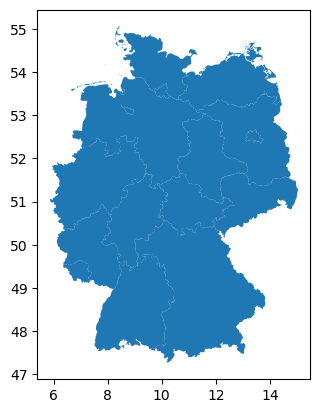

In [59]:
bl.plot()

In [70]:
europe_clean

Index(['Russia', 'Norway', 'France', 'Sweden', 'Belarus', 'Ukraine', 'Poland',
       'Austria', 'Hungary', 'Moldova', 'Romania', 'Lithuania', 'Latvia',
       'Estonia', 'Germany', 'Bulgaria', 'Greece', 'Albania', 'Croatia',
       'Switzerland', 'Luxembourg', 'Belgium', 'Netherlands', 'Portugal',
       'Spain', 'Ireland', 'Italy', 'Denmark', 'United Kingdom', 'Iceland',
       'Slovenia', 'Finland', 'Slovakia', 'Czechia', 'Bosnia and Herz.',
       'Macedonia', 'Serbia', 'Montenegro', 'Kosovo'],
      dtype='object', name='name')

In [69]:
europe_clean

Index(['Russia', 'Norway', 'France', 'Sweden', 'Belarus', 'Ukraine', 'Poland',
       'Austria', 'Hungary', 'Moldova', 'Romania', 'Lithuania', 'Latvia',
       'Estonia', 'Germany', 'Bulgaria', 'Greece', 'Albania', 'Croatia',
       'Switzerland', 'Luxembourg', 'Belgium', 'Netherlands', 'Portugal',
       'Spain', 'Ireland', 'Italy', 'Denmark', 'United Kingdom', 'Iceland',
       'Slovenia', 'Finland', 'Slovakia', 'Czechia', 'Bosnia and Herz.',
       'Macedonia', 'Serbia', 'Montenegro', 'Kosovo'],
      dtype='object', name='name')

In [44]:
data = gpd.read_file('Landkreise.geojson',encoding='latin1')
data_df = pd.read_csv('Landkreise.csv',encoding='latin1')

In [45]:
data

,name,USE,RS,RS_ALT,SHAPE_LENG,SHAPE_AREA,N_powerplants,N_green,green_ratio,N_fuel_Hydro,fuel_ratio_Hydro,fuel_generation_ratio_Hydro,fuel_generation_total_Hydro,N_fuel_Solar,fuel_ratio_Solar,fuel_generation_ratio_Solar,fuel_generation_total_Solar,N_fuel_Gas,fuel_ratio_Gas,fuel_generation_ratio_Gas,fuel_generation_total_Gas,N_fuel_Biomass,fuel_ratio_Biomass,fuel_generation_ratio_Biomass,fuel_generation_total_Biomass,N_fuel_Coal,fuel_ratio_Coal,fuel_generation_ratio_Coal,fuel_generation_total_Coal,N_fuel_Other,fuel_ratio_Other,fuel_generation_ratio_Other,fuel_generation_total_Other,N_fuel_Waste,fuel_ratio_Waste,fuel_generation_ratio_Waste,fuel_generation_total_Waste,N_fuel_Wind,fuel_ratio_Wind,fuel_generation_ratio_Wind,fuel_generation_total_Wind,N_fuel_Oil,fuel_ratio_Oil,fuel_generation_ratio_Oil,fuel_generation_total_Oil,N_fuel_Nuclear,fuel_ratio_Nuclear,fuel_generation_ratio_Nuclear,fuel_generation_total_Nuclear,geometry
0,Flensburg,4,01001,010010000000,32467.034276,5.324899e+07,1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,1.0,1.0,1.000000,958.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((9.48982 54.82296, 9.50467 54.81004, 9.50500 54.80693, 9.50436 54.77557, 9.50021 54.772..."
1,Kiel,4,01002,010020000000,73027.302434,1.218654e+08,2.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,1.0,0.5,0.070329,120.13,0.0,0.000000,0.0,0.0,1.0,0.5,0.929671,1587.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((10.19057 54.38909, 10.18370 54.38910, 10.17815 54.38874, 10.16139 54.38413, 10.14303 5..."
2,Lübeck,4,01003,010030000000,104861.094220,2.211386e+08,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((10.89297 53.95695, 10.90337 53.95705, 10.90860 53.94543, 10.91239 53.92356, 10.96060 5..."
3,Neumünster,4,01004,010040000000,39858.818376,8.092363e+07,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((10.03454 54.12915, 10.02277 54.10938, 10.02270 54.06161, 10.02759 54.05906, 10.04121 5..."
4,Dithmarschen,4,01051,010510000000,202206.675707,1.450311e+09,3.0,3.0,1.0,0.0,0.000000,0.000000,0.00,3.0,1.000000,1.000000,27.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((9.05176 54.36640, 9.07193 54.36254, 9.08642 54.36935, 9.08862 54.37006, 9.09035 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,Saalfeld-Rudolstadt,4,16073,160730000000,209670.746788,1.023057e+09,2.0,1.0,0.5,1.0,0.500000,0.858969,625.45,0.0,0.000000,0.000000,0.00,1.0,0.5,0.141031,102.69,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((11.42397 50.80862, 11.42072 50.80306, 11.42711 50.79708, 11.43409 50.79457, 11.43986 5..."
398,Saale-Holzland-Kreis,4,16074,160740000000,172686.880125,8.176883e+08,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((12.01807 50.96757, 12.02085 50.94806, 11.99185 50.95280, 11.98029 50.95224, 11.96078 5..."
399,Saale-Orla-Kreis,4,16075,160750000000,185679.957051,1.144877e+09,3.0,3.0,1.0,1.0,0.333333,0.920856,187.56,1.0,0.333333,0.079144,16.12,0.0,0.0,0.000000,0.00,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0

In [46]:
data_df

,name,USE,RS,RS_ALT,SHAPE_LENG,SHAPE_AREA,geometry,N_powerplants,N_green,green_ratio,N_fuel_Hydro,fuel_ratio_Hydro,fuel_generation_ratio_Hydro,fuel_generation_total_Hydro,N_fuel_Solar,fuel_ratio_Solar,fuel_generation_ratio_Solar,fuel_generation_total_Solar,N_fuel_Gas,fuel_ratio_Gas,fuel_generation_ratio_Gas,fuel_generation_total_Gas,N_fuel_Biomass,fuel_ratio_Biomass,fuel_generation_ratio_Biomass,fuel_generation_total_Biomass,N_fuel_Coal,fuel_ratio_Coal,fuel_generation_ratio_Coal,fuel_generation_total_Coal,N_fuel_Other,fuel_ratio_Other,fuel_generation_ratio_Other,fuel_generation_total_Other,N_fuel_Waste,fuel_ratio_Waste,fuel_generation_ratio_Waste,fuel_generation_total_Waste,N_fuel_Wind,fuel_ratio_Wind,fuel_generation_ratio_Wind,fuel_generation_total_Wind,N_fuel_Oil,fuel_ratio_Oil,fuel_generation_ratio_Oil,fuel_generation_total_Oil,N_fuel_Nuclear,fuel_ratio_Nuclear,fuel_generation_ratio_Nuclear,fuel_generation_total_Nuclear
0,Flensburg,4,1001,10010000000,32467.034276,5.324899e+07,"POLYGON ((9.489823260151168 54.82296231149822, 9.504673652057674 54.81004002875278, 9.5049951708...",1.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,1.0,1.0,1.000000,958.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Kiel,4,1002,10020000000,73027.302434,1.218654e+08,"POLYGON ((10.190574858682838 54.38909396612953, 10.183698316104081 54.38910380529061, 10.1781475...",2.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,1.0,0.5,0.070329,120.13,0.0,0.000000,0.0,0.0,1.0,0.5,0.929671,1587.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Lübeck,4,1003,10030000000,104861.094220,2.211386e+08,"POLYGON ((10.892971221748953 53.956954865124764, 10.903374439173431 53.957047375648436, 10.90859...",0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Neumünster,4,1004,10040000000,39858.818376,8.092363e+07,"POLYGON ((10.034541478286 54.129152216881, 10.022771700029574 54.10937690486711, 10.022703338048...",0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Dithmarschen,4,1051,10510000000,202206.675707,1.450311e+09,"MULTIPOLYGON (((9.051759426136824 54.36640406899298, 9.071925934905774 54.36253959382538, 9.0864...",3.0,3.0,1.0,0.0,0.000000,0.000000,0.00,3.0,1.000000,1.000000,27.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,Saalfeld-Rudolstadt,4,16073,160730000000,209670.746788,1.023057e+09,"POLYGON ((11.423971579497547 50.808616322167495, 11.420723318775645 50.80306320426556, 11.427107...",2.0,1.0,0.5,1.0,0.500000,0.858969,625.45,0.0,0.000000,0.000000,0.00,1.0,0.5,0.141031,102.69,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,Saale-Holzland-Kreis,4,16074,160740000000,172686.880125,8.176883e+08,"POLYGON ((12.018066692496834 50.96756663064153, 12.020848297713496 50.948064672848666, 11.991852...",0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399,Saale-Orla-Kreis,4,16075,160750000000,185679.957051,1.144877e+09,"POLYGON ((11.944821365827302 50.59236465292197, 11.924229684021926 50.58607793152918, 11.9298359...",3.0,3.0,1.0,1.0,0.333333,0.920856,187.56,1.0,0.333333,0.0